--- BẮT ĐẦU VẼ TỔNG HỢP CHO BRUSSELS, BERLIN, PARIS ---
--- ĐANG NẠP DỮ LIỆU TỔNG HỢP ---


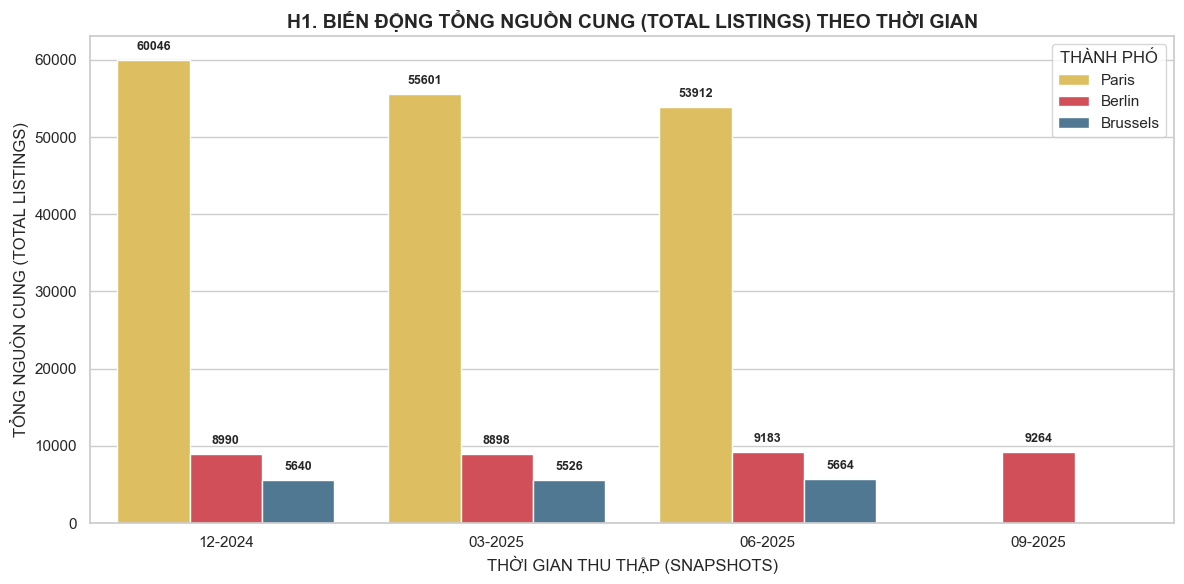

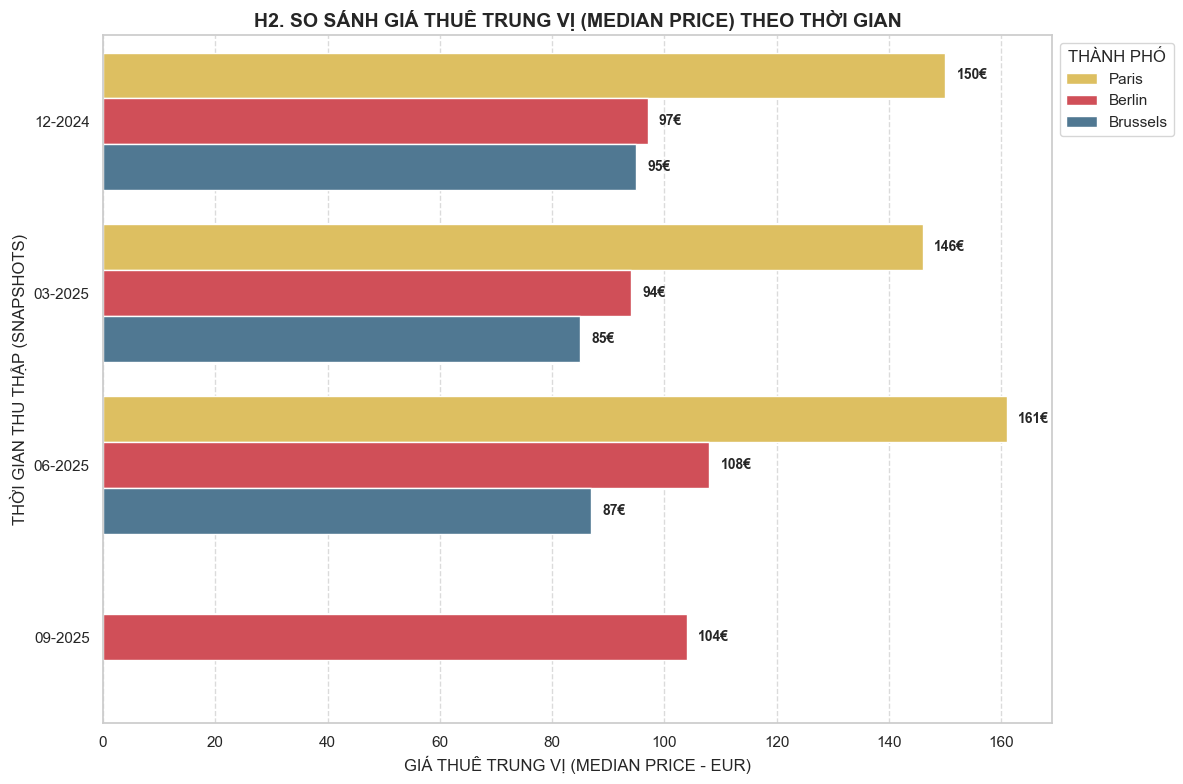

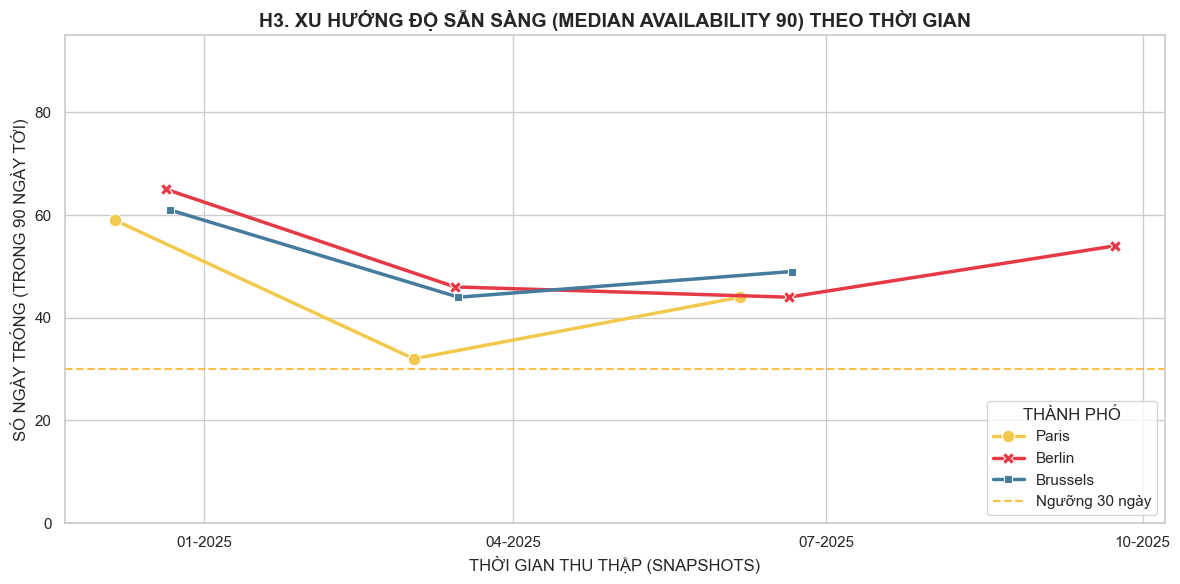

<Figure size 1000x700 with 0 Axes>

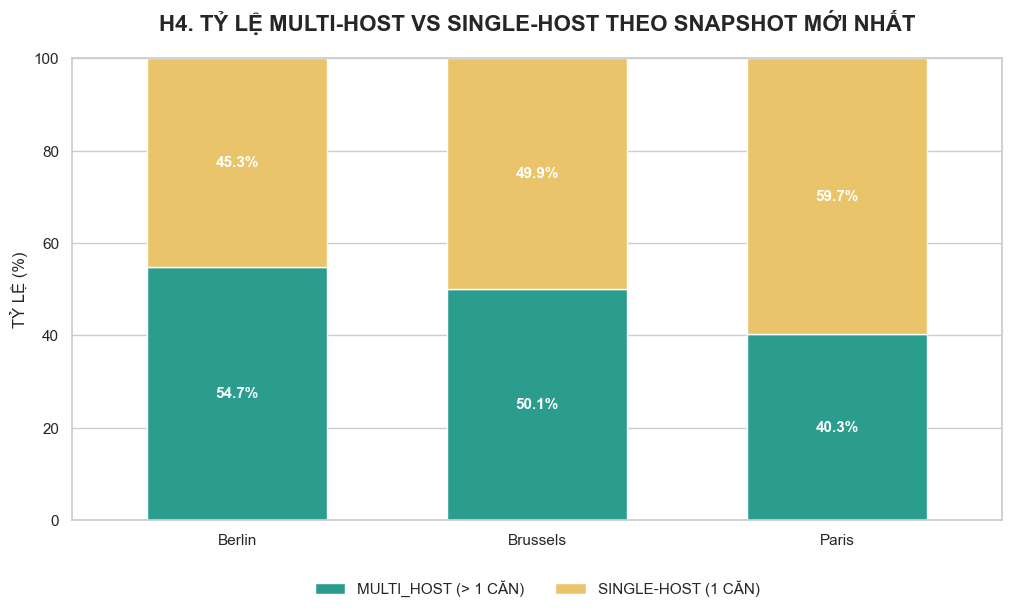

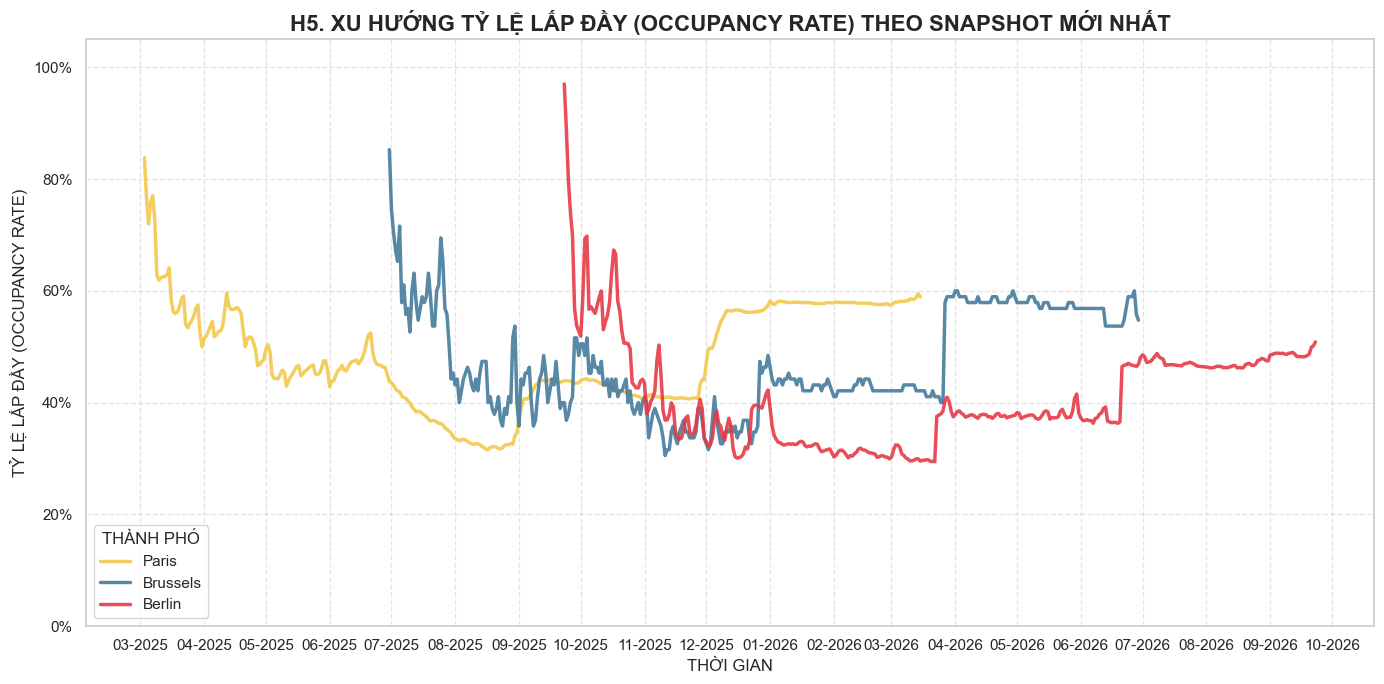

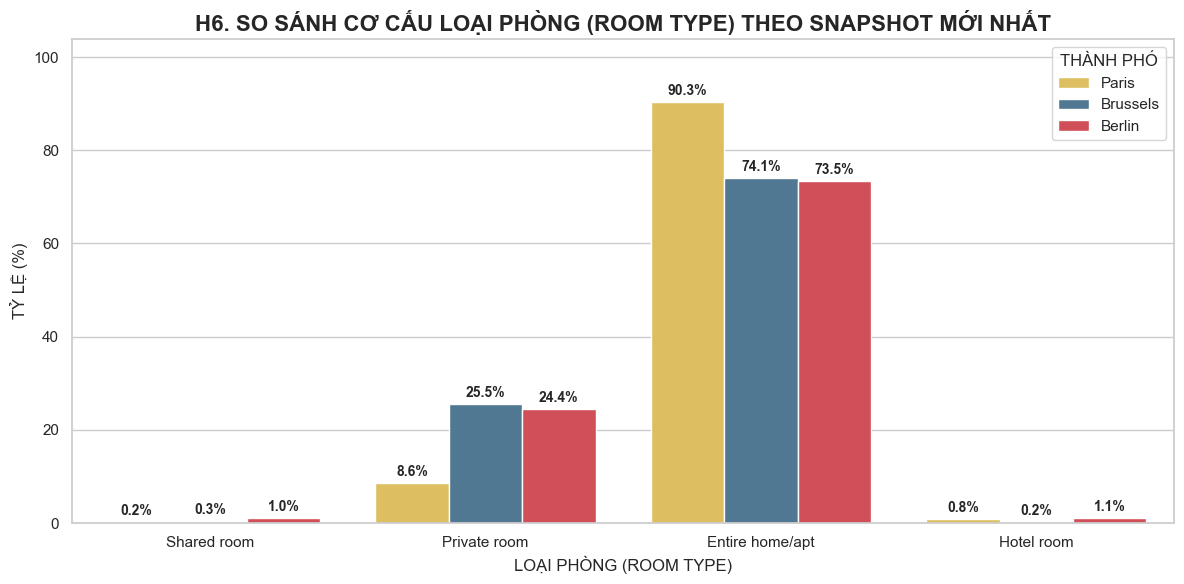

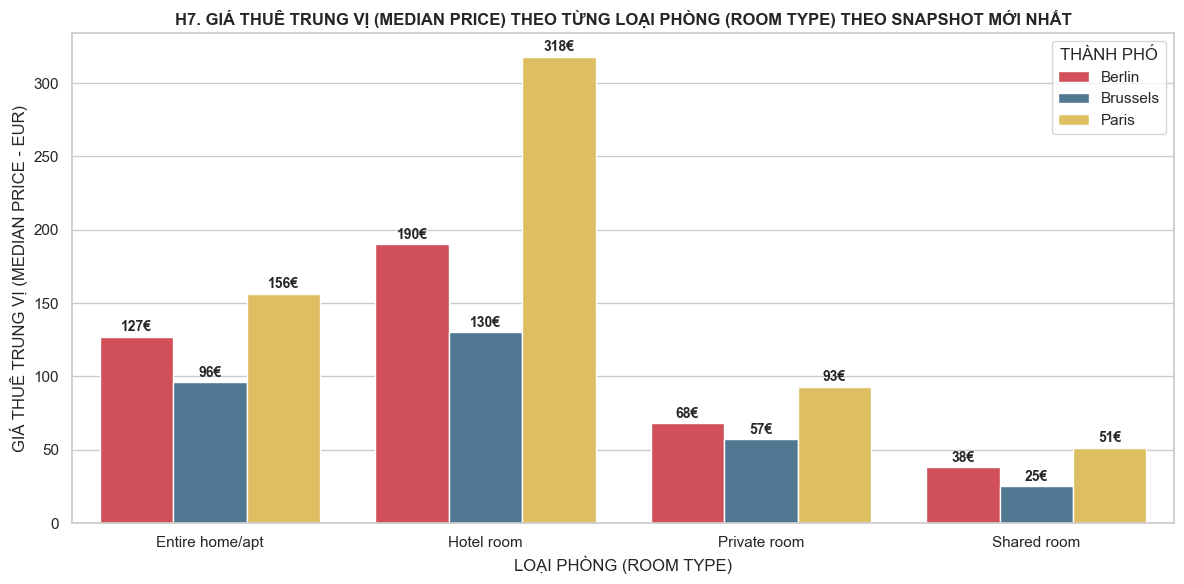

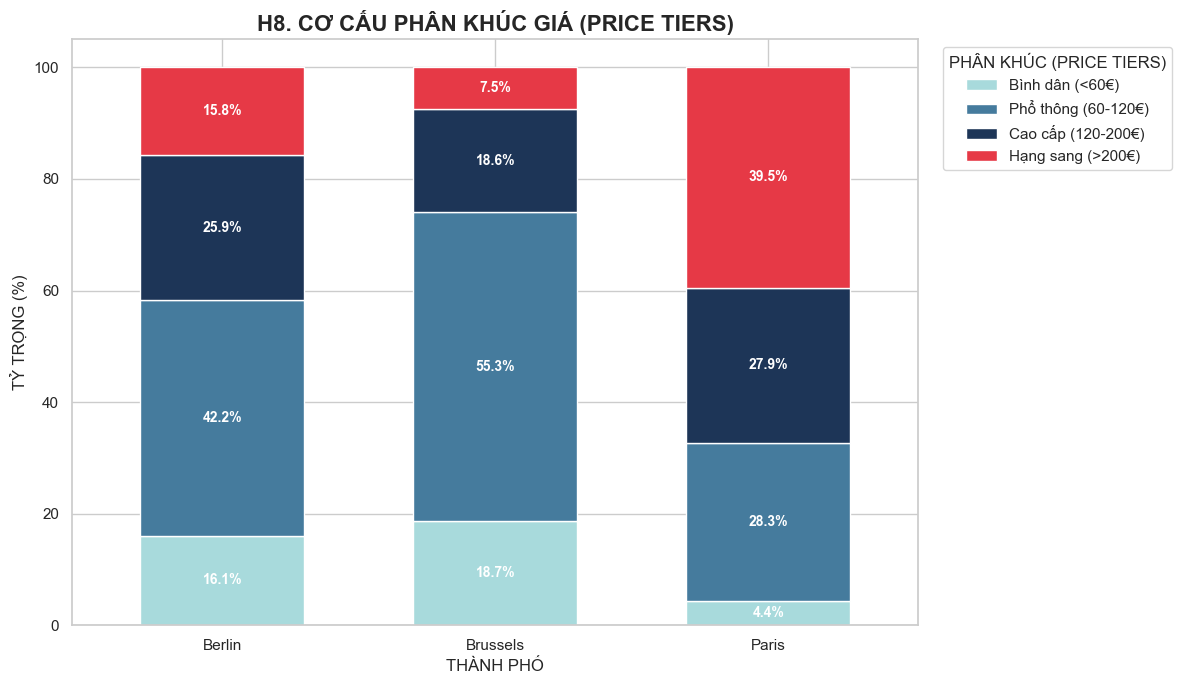

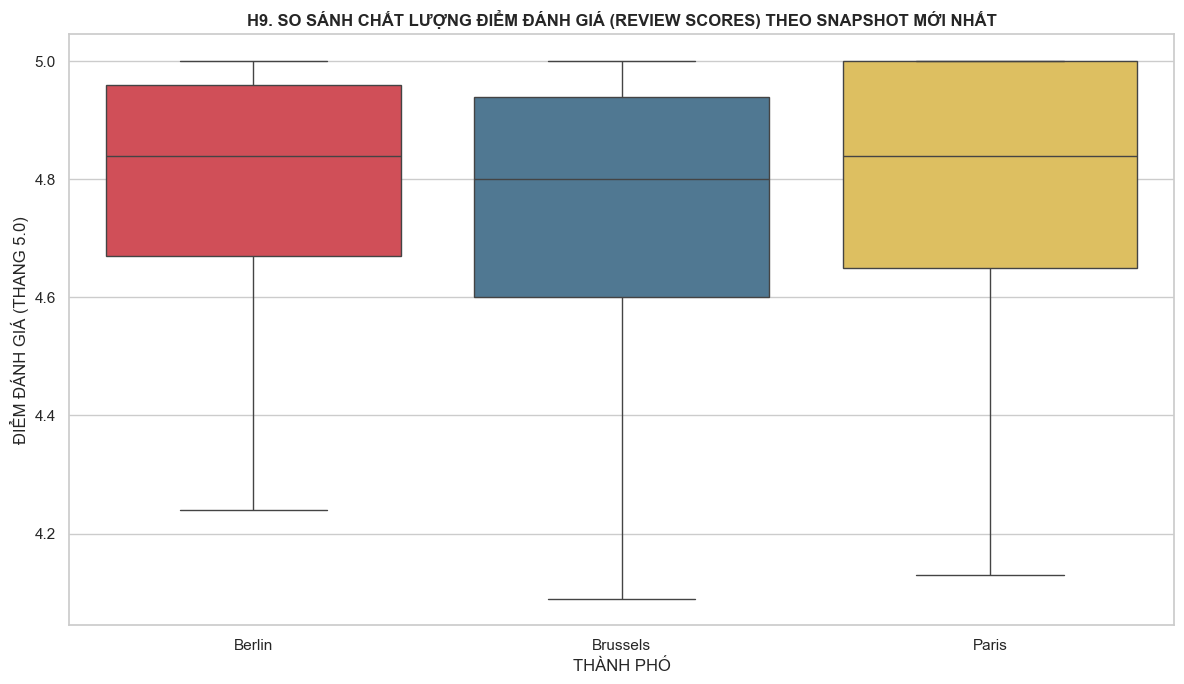

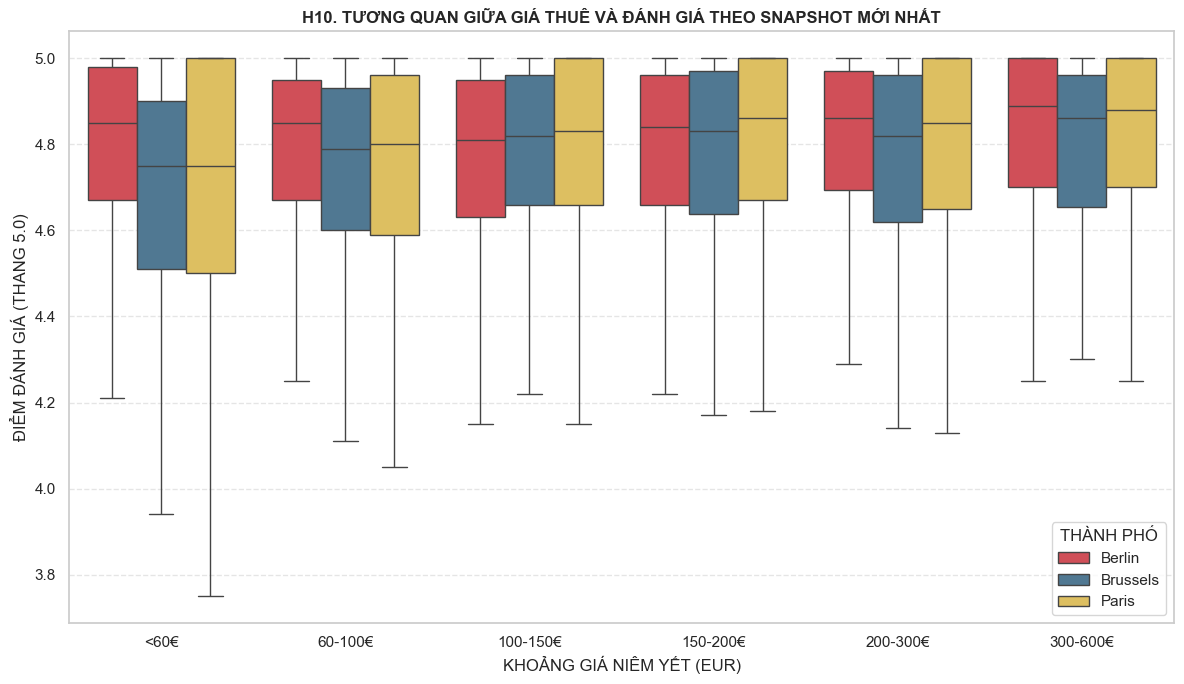

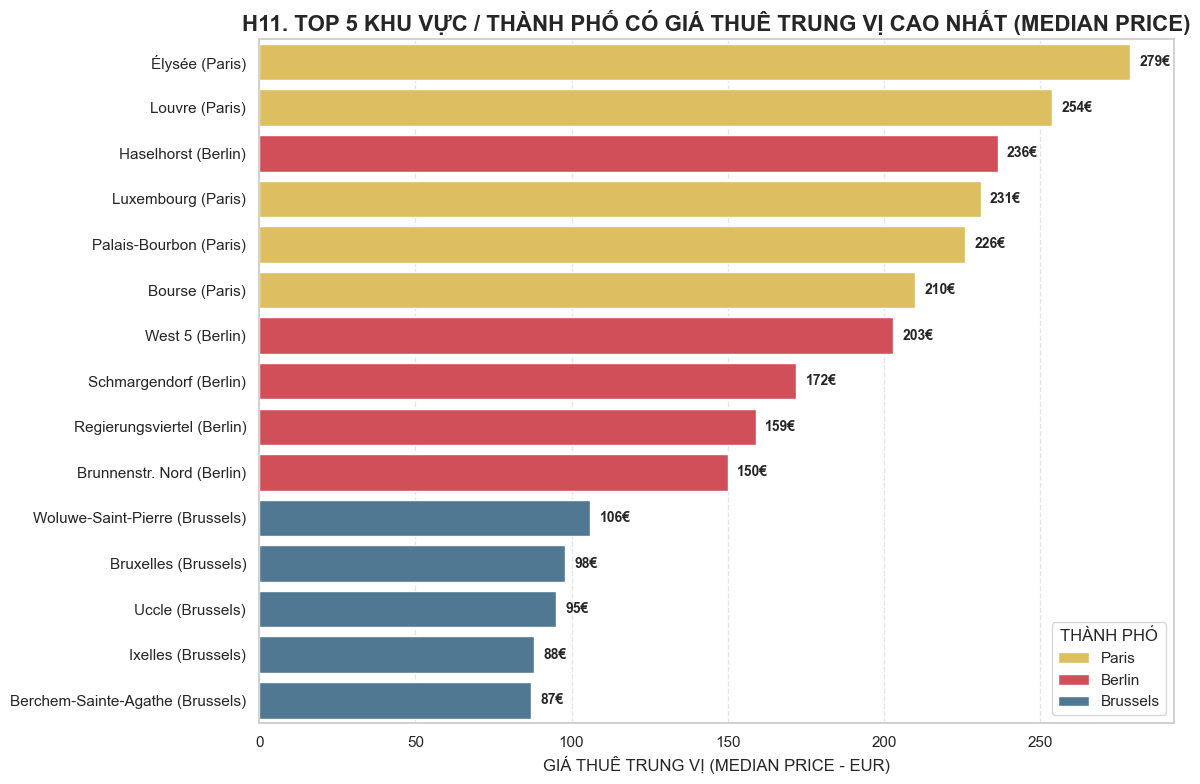

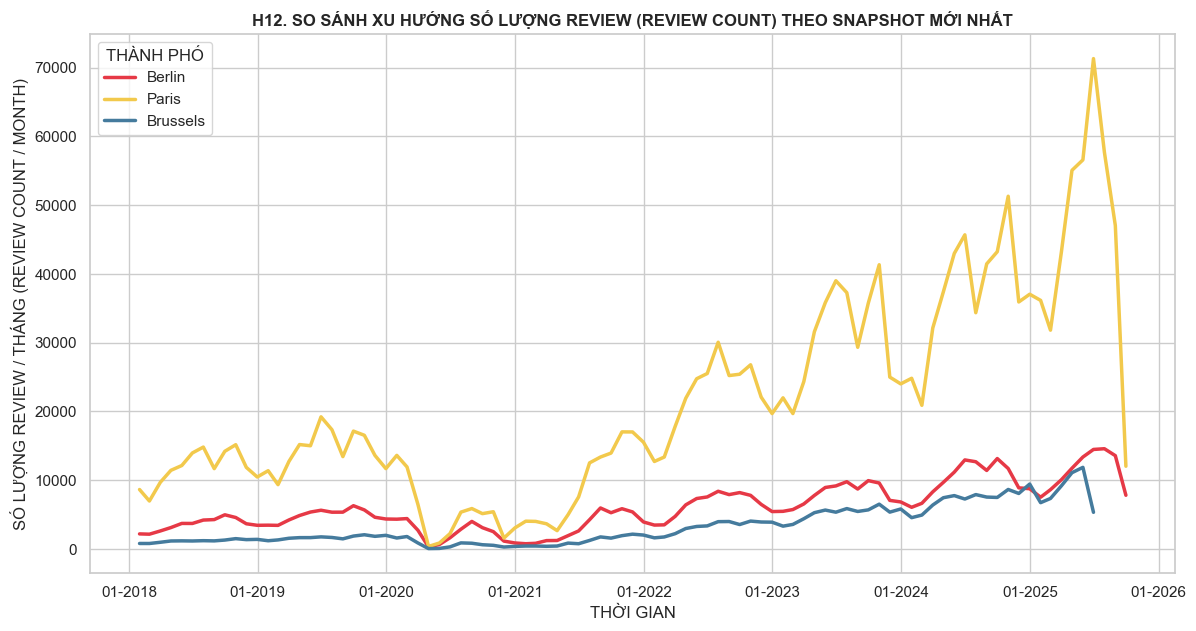

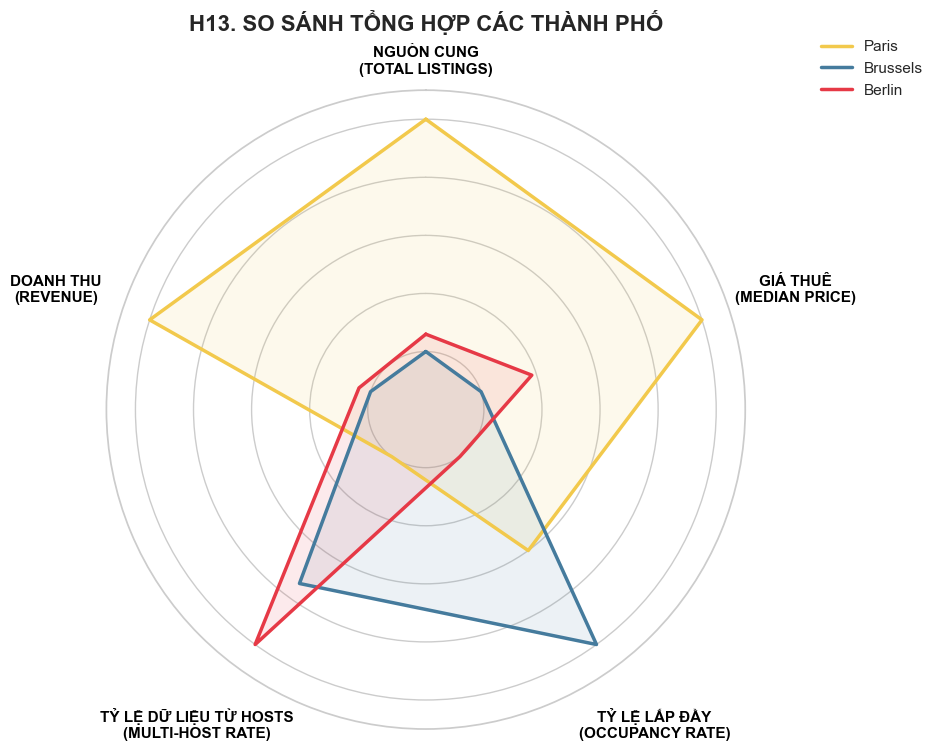

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from math import pi
from datetime import datetime

# ==============================================================================
# 0. CONFIG
# ==============================================================================
BASE_DIR = '..'
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)

sns.set_theme(style="whitegrid")
plt.rcParams.update({'figure.figsize': (12, 6), 'font.size': 12})

CITY_COLORS = {
    'Berlin': '#E63946',
    'Brussels': '#457B9D',
    'Paris': '#F2C94C'
}

# ==============================================================================
# HELPERS
# ==============================================================================
def safe_capitalize_city(name):
    """Normalize city folder name -> Title case single token (Berlin, Brussels, Paris)."""
    if not isinstance(name, str): 
        return name
    name = name.strip()
    # if folder contains underscores or spaces, take first token (assumes structure processed/<city>/...)
    token = name.split(os.sep)[-1].split('_')[0].split()[0]
    return token.capitalize()

def parse_flexible_date(s):
    """Try several likely date formats, return pd.Timestamp or NaT."""
    if pd.isna(s): 
        return pd.NaT
    s = str(s).strip()
    formats = ["%d %B, %Y", "%d %B %Y", "%Y-%m-%d", "%d-%m-%Y", "%d %b, %Y", "%d %b %Y"]
    for fmt in formats:
        try:
            return pd.to_datetime(datetime.strptime(s, fmt))
        except Exception:
            continue
    # fallback to pandas parser
    try:
        return pd.to_datetime(s, dayfirst=True, errors='coerce')
    except:
        return pd.NaT

def load_kpi_data(pattern):
    """Load KPI files matching pattern under processed/*/<pattern> and append City column."""
    all_files = glob.glob(os.path.join(PROCESSED_DIR, '*', pattern))
    df_list = []
    for f in all_files:
        city_folder = os.path.basename(os.path.dirname(f))
        city = safe_capitalize_city(city_folder)
        try:
            df = pd.read_csv(f)
            df['City'] = city
            df_list.append(df)
        except Exception:
            continue
    return pd.concat(df_list, ignore_index=True) if df_list else pd.DataFrame()

def load_latest_listing_for_city(city):
    """Return the most recent listings_processed.csv for a given city folder (by parsing snapshot folder names)."""
    city_path = os.path.join(PROCESSED_DIR, city.lower())
    if not os.path.exists(city_path):
        # try capitalized
        city_path = os.path.join(PROCESSED_DIR, city)
        if not os.path.exists(city_path):
            return pd.DataFrame()
    # get folders
    folders = [d for d in os.listdir(city_path) if os.path.isdir(os.path.join(city_path, d))]
    # parse dates
    folder_dates = []
    for f in folders:
        dt = parse_flexible_date(f)
        if not pd.isna(dt):
            folder_dates.append((f, dt))
    if not folder_dates:
        return pd.DataFrame()
    # sort by date desc and pick first valid file
    folder_dates = sorted(folder_dates, key=lambda x: x[1], reverse=True)
    for f, _ in folder_dates:
        fp = os.path.join(city_path, f, 'listings_processed.csv')
        if os.path.exists(fp):
            try:
                df = pd.read_csv(fp, low_memory=False)
                if not df.empty and 'price_numeric' in df.columns and df['price_numeric'].notna().sum() > 0:
                    df['City'] = safe_capitalize_city(city)
                    return df
            except Exception:
                continue
    return pd.DataFrame()

# ==============================================================================
# 1. LOAD KPI SUMMARY / ROOM / SEASONALITY
# ==============================================================================
print("--- BẮT ĐẦU VẼ TỔNG HỢP CHO BRUSSELS, BERLIN, PARIS ---")
print("--- ĐANG NẠP DỮ LIỆU TỔNG HỢP ---")
df_summary = load_kpi_data('kpi_summary_general_*.csv')
df_room = load_kpi_data('kpi_room_type_*.csv')
df_season = load_kpi_data('kpi_seasonality_*.csv')
df_neigh_kpi = load_kpi_data('kpi_neighbourhood_*.csv')
df_review_kpi = load_kpi_data('kpi_reviews_trend_*.csv')

# Clean summary
if not df_summary.empty:
    # ensure numeric where expected
    for col in ['total_listings', 'median_price', 'median_avail_90', 'multi_host_rate']:
        if col in df_summary.columns:
            df_summary[col] = pd.to_numeric(df_summary[col], errors='coerce')
    df_clean_sum = df_summary[(df_summary['total_listings'].fillna(0) > 0) & (df_summary.get('median_price').notna())].copy()
    df_clean_sum['snapshot_dt'] = df_clean_sum['snapshot_date'].apply(parse_flexible_date)
    df_clean_sum = df_clean_sum.dropna(subset=['snapshot_dt'])
    valid_keys = set(zip(df_clean_sum['City'], df_clean_sum['snapshot_date']))
else:
    print("⚠️ Không có dữ liệu summary!")
    df_clean_sum = pd.DataFrame()
    valid_keys = set()

# ==============================================================================
# 2. PLOTS H1-H6
# ==============================================================================

# H1: Total listings (bar by snapshot month-year, grouped by city)
if not df_summary.empty:
    df_h1 = df_summary.copy()
    df_h1['snapshot_dt'] = df_h1['snapshot_date'].apply(parse_flexible_date)
    df_h1 = df_h1.dropna(subset=['snapshot_dt'])
    df_h1['Period'] = df_h1['snapshot_dt'].dt.strftime('%m-%Y')
    df_h1 = df_h1.sort_values('snapshot_dt')

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=df_h1, x='Period', y='total_listings', hue='City', palette=CITY_COLORS)
    for p in ax.patches:
        h = p.get_height()
        if h and h > 0:
            ax.annotate(f'{int(h)}', (p.get_x() + p.get_width() / 2., h),
                        ha='center', va='bottom', xytext=(0, 5), textcoords='offset points',
                        fontsize=9, fontweight='bold')
    plt.title('H1. BIẾN ĐỘNG TỔNG NGUỒN CUNG (TOTAL LISTINGS) THEO THỜI GIAN', fontweight='bold', fontsize=14)
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.ylabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.legend(title='THÀNH PHỐ', loc='upper right')
    save_path = os.path.join(FIGURES_DIR, 'H01_Total_Supply_All_Snapshots.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.show()
    

# H2: Median price (horizontal)
if not df_clean_sum.empty:
    df_h2 = df_clean_sum.copy()
    df_h2 = df_h2.sort_values('snapshot_dt')
    df_h2['Period'] = df_h2['snapshot_dt'].dt.strftime('%m-%Y')

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=df_h2, x='median_price', y='Period', hue='City', palette=CITY_COLORS, orient='h')

    for p in ax.patches:
        width = p.get_width()
        if width and width > 0:
            ax.text(width + 2, p.get_y() + p.get_height() / 2, f'{int(width)}€',
                    ha='left', va='center', fontsize=10, fontweight='bold')
    plt.title('H2. SO SÁNH GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) THEO THỜI GIAN', fontweight='bold', fontsize=14)
    plt.xlabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.ylabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.legend(title='THÀNH PHỐ', bbox_to_anchor=(1, 1))
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    save_path = os.path.join(FIGURES_DIR, 'H02_Median_Price_Horizontal.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.show()
    

# H3: Availability trend (median_avail_90)
if not df_clean_sum.empty and 'median_avail_90' in df_clean_sum.columns:
    df_h3 = df_clean_sum[df_clean_sum['median_avail_90'].notna()].copy()
    df_h3 = df_h3.sort_values('snapshot_dt')
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_h3, x='snapshot_dt', y='median_avail_90', hue='City', palette=CITY_COLORS,
                 style='City', markers=True, dashes=False, linewidth=2.5, markersize=9)
    plt.axhline(30, color='orange', linestyle='--', alpha=0.7, label='Ngưỡng 30 ngày')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.title('H3. XU HƯỚNG ĐỘ SẴN SÀNG (MEDIAN AVAILABILITY 90) THEO THỜI GIAN', fontweight='bold', fontsize=14)
    plt.ylabel('SỐ NGÀY TRỐNG (TRONG 90 NGÀY TỚI)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.ylim(0, 95)
    plt.legend(title='THÀNH PHỐ', loc='lower right')
    save_path = os.path.join(FIGURES_DIR, 'H03_Availability_Trend.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.show()
    

# H4: Multi-host stacked bar (latest snapshot per city)
if not df_clean_sum.empty and 'multi_host_rate' in df_clean_sum.columns:
    df_latest = df_clean_sum.sort_values('snapshot_dt').groupby('City').tail(1).copy()
    df_latest['single_host_rate'] = 100 - df_latest['multi_host_rate']
    plot_data = df_latest.set_index('City')[['multi_host_rate', 'single_host_rate']]
    plot_data = plot_data.sort_values('multi_host_rate', ascending=False)
    plt.figure(figsize=(10, 7))
    ax = plot_data.plot(kind='bar', stacked=True, color=['#2A9D8F', '#E9C46A'], width=0.6, rot=0)
    for c in ax.containers:
        labels = [f'{v.get_height():.1f}%' if v.get_height() > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', fontsize=11, fontweight='bold', color='white')
    plt.title('H4. TỶ LỆ MULTI-HOST VS SINGLE-HOST THEO SNAPSHOT MỚI NHẤT', fontweight='bold', fontsize=16, pad=20)
    plt.ylabel('TỶ LỆ (%)')
    plt.xlabel('')
    plt.ylim(0, 100)
    plt.legend(['MULTI_HOST (> 1 CĂN)', 'SINGLE-HOST (1 CĂN)'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=False)
    save_path = os.path.join(FIGURES_DIR, 'H04_MultiHost_Stacked.pdf')
    plt.savefig(save_path, format='pdf', bbox_inches='tight', pad_inches=0.5)
    plt.show()
    

# H5: Occupancy rate - plot daily series for latest snapshot per city
if not df_season.empty and 'date' in df_season.columns and 'occupancy_rate' in df_season.columns:
    df_h5 = df_season.copy()
    df_h5['date_dt'] = pd.to_datetime(df_h5['date'], errors='coerce')
    df_h5['snapshot_dt'] = df_h5['snapshot_date'].apply(parse_flexible_date)
    df_h5 = df_h5.dropna(subset=['snapshot_dt'])
    latest_snaps = df_h5.groupby('City')['snapshot_dt'].max()
    df_final_h5 = df_h5[df_h5.apply(lambda r: r['snapshot_dt'] == latest_snaps.get(r['City'], pd.NaT), axis=1)]
    df_final_h5 = df_final_h5.sort_values('date_dt')
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df_final_h5, x='date_dt', y='occupancy_rate', hue='City', palette=CITY_COLORS, linewidth=2.5, alpha=0.9)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.title('H5. XU HƯỚNG TỶ LỆ LẤP ĐẦY (OCCUPANCY RATE) THEO SNAPSHOT MỚI NHẤT', fontweight='bold', fontsize=16)
    plt.ylabel('TỶ LỆ LẤP ĐẦY (OCCUPANCY RATE)')
    plt.xlabel('THỜI GIAN')
    plt.legend(title='THÀNH PHỐ', loc='lower left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.ylim(0, 1.05)
    save_path = os.path.join(FIGURES_DIR, 'H05_Occupancy_Rate_LineChart.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.show()
    

# H6: Room type composition (latest snapshot)
if not df_room.empty and not df_clean_sum.empty:
    
    df_room = df_room.copy()
    df_room['key'] = list(zip(df_room['City'], df_room['snapshot_date']))
    df_room_clean = df_room[df_room['key'].isin(valid_keys)].copy()
    df_room_clean['snapshot_dt'] = df_room_clean['snapshot_date'].apply(parse_flexible_date)
    latest_room = df_room_clean.sort_values('snapshot_dt').groupby(['City', 'room_type']).tail(1)
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=latest_room, x='room_type', y='percentage', hue='City', palette=CITY_COLORS)
    for p in ax.patches:
        height = p.get_height()
        if height and height > 0:
            ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', xytext=(0, 3), textcoords='offset points', fontweight='bold', fontsize=10)
    plt.title('H6. SO SÁNH CƠ CẤU LOẠI PHÒNG (ROOM TYPE) THEO SNAPSHOT MỚI NHẤT', fontweight='bold', fontsize=16)
    plt.ylabel('TỶ LỆ (%)')
    plt.xlabel('LOẠI PHÒNG (ROOM TYPE)')
    plt.legend(title='THÀNH PHỐ')
    if not latest_room['percentage'].empty:
        plt.ylim(0, latest_room['percentage'].max() * 1.15)
    save_path = os.path.join(FIGURES_DIR, 'H06_Room_Type_GroupedBar.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.show()



# ==============================================================================
# 3. LOAD RAW LISTINGS LATEST PER CITY 
# ==============================================================================
cities_list = ['berlin', 'brussels', 'paris']
df_listings_all = []
for city in cities_list:
    df_city = load_latest_listing_for_city(city)
    if not df_city.empty:
        df_listings_all.append(df_city)
df_detail = pd.concat(df_listings_all, ignore_index=True) if df_listings_all else pd.DataFrame()



# H7: Price by Room Type (Grouped Bar)
if not df_detail.empty and 'review_scores_rating' in df_detail.columns:
    df_clean = df_detail.copy()
    df_clean['review_scores_rating'] = pd.to_numeric(df_clean['review_scores_rating'], errors='coerce')
    df_clean['price_numeric'] = pd.to_numeric(df_clean['price_numeric'], errors='coerce')
    df_clean = df_clean.dropna(subset=['review_scores_rating', 'price_numeric', 'room_type'])
    price_room = df_clean.groupby(['City', 'room_type'])['price_numeric'].median().reset_index()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=price_room, x='room_type', y='price_numeric', 
                hue='City', palette=CITY_COLORS)
    plt.title('H7. GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) THEO TỪNG LOẠI PHÒNG (ROOM TYPE) THEO SNAPSHOT MỚI NHẤT', fontweight='bold')
    plt.ylabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.xlabel('LOẠI PHÒNG (ROOM TYPE)')
    plt.legend(title = 'THÀNH PHỐ', loc = 'upper right')
    ax = plt.gca()
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{int(p.get_height())}€', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=10, fontweight='bold', xytext=(0, 2), textcoords='offset points')

    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'H07_Price_RoomType.pdf'))
    plt.show()
    



# H8: Price segments stacked bar
if not df_detail.empty and 'price_numeric' in df_detail.columns:
    bins = [0, 60, 120, 200, 99999]
    labels = ['Bình dân (<60€)', 'Phổ thông (60-120€)', 'Cao cấp (120-200€)', 'Hạng sang (>200€)']
    df_detail['price_numeric'] = pd.to_numeric(df_detail['price_numeric'], errors='coerce')
    df_detail = df_detail.dropna(subset=['price_numeric'])
    df_detail['Price_Tier'] = pd.cut(df_detail['price_numeric'], bins=bins, labels=labels, right=False)
    tier_counts = df_detail.groupby(['City', 'Price_Tier'], observed=True).size().reset_index(name='count')
    total_counts = df_detail.groupby('City')['price_numeric'].count().reset_index(name='total')
    tier_data = tier_counts.merge(total_counts, on='City')
    tier_data['percentage'] = (tier_data['count'] / tier_data['total']) * 100
    pivot_tier = tier_data.pivot(index='City', columns='Price_Tier', values='percentage').fillna(0)
    colors = ['#A8DADC', '#457B9D', '#1D3557', '#E63946']
    ax = pivot_tier.plot(kind='bar', stacked=True, figsize=(12, 7), color=colors, rot=0, width=0.6)
    for c in ax.containers:
        labels_text = [f'{v.get_height():.1f}%' if v.get_height() > 3 else '' for v in c]
        ax.bar_label(c, labels=labels_text, label_type='center', color='white', fontweight='bold', fontsize=10)
    plt.title('H8. CƠ CẤU PHÂN KHÚC GIÁ (PRICE TIERS)', fontweight='bold', fontsize=16)
    plt.xlabel('THÀNH PHỐ')
    plt.ylabel('TỶ TRỌNG (%)')
    plt.legend(title='PHÂN KHÚC (PRICE TIERS)', bbox_to_anchor=(1.02, 1), loc='upper left')
    save_path = os.path.join(FIGURES_DIR, 'H08_Price_Segments.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.show()


    # H9: Quality Comparison (Boxplot)
    # -------------------------------------------------------
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=df_clean, x='City', y='review_scores_rating', 
                hue='City', palette=CITY_COLORS, showfliers=False, legend=False)
    plt.title('H9. SO SÁNH CHẤT LƯỢNG ĐIỂM ĐÁNH GIÁ (REVIEW SCORES) THEO SNAPSHOT MỚI NHẤT', fontweight='bold')
    plt.xlabel('THÀNH PHỐ')
    plt.ylabel('ĐIỂM ĐÁNH GIÁ (THANG 5.0)')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'H09_Quality_Scores.pdf'))
    plt.show()

    # H10: COMPARE PRICE AND REVIEWS
    plt.figure(figsize=(12, 7))
    price_bins = [0, 60, 100, 150, 200, 300, 600]
    bin_labels = ['<60€', '60-100€', '100-150€', '150-200€', '200-300€', '300-600€']
    df_clean.loc[:, 'price_range_group'] = pd.cut(df_clean['price_numeric'], bins=price_bins, labels=bin_labels)
    sns.boxplot(data=df_clean, x='price_range_group', y='review_scores_rating', 
                hue='City', palette=CITY_COLORS, showfliers=False) 
    
    plt.title('H10. TƯƠNG QUAN GIỮA GIÁ THUÊ VÀ ĐÁNH GIÁ THEO SNAPSHOT MỚI NHẤT', fontweight='bold')
    plt.xlabel('KHOẢNG GIÁ NIÊM YẾT (EUR)')
    plt.ylabel('ĐIỂM ĐÁNH GIÁ (THANG 5.0)')
    plt.legend(title='THÀNH PHỐ', loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'H10_Price_Quality_Boxplot.pdf'))
    plt.show()
    

# H11: Top neighborhoods by median price (top 5 per city)
if not df_detail.empty and 'neighbourhood_cleansed' in df_detail.columns and 'price_numeric' in df_detail.columns:
    df_detail = df_detail[df_detail['neighbourhood_cleansed'].notna()].copy()
    neigh_stats = df_detail.groupby(['City', 'neighbourhood_cleansed'], observed=True)['price_numeric'].median().reset_index()
    top_neighs = neigh_stats.sort_values(['City', 'price_numeric'], ascending=[True, False]).groupby('City').head(5)
    top_neighs = top_neighs.sort_values('price_numeric', ascending=False)
    top_neighs['Label'] = top_neighs['neighbourhood_cleansed'] + " (" + top_neighs['City'] + ")"

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=top_neighs, x='price_numeric', y='Label', hue='City', palette=CITY_COLORS, dodge=False)
    for p in ax.patches:
        width = p.get_width()
        if width and width > 0:
            ax.text(width + 3, p.get_y() + p.get_height() / 2, f'{int(width)}€', va='center', fontweight='bold', fontsize=10)
    plt.title('H11. TOP 5 KHU VỰC / THÀNH PHỐ CÓ GIÁ THUÊ TRUNG VỊ CAO NHẤT (MEDIAN PRICE)', fontweight='bold', fontsize=16)
    plt.xlabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.ylabel('')
    plt.legend(title='THÀNH PHỐ', loc='lower right')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    save_path = os.path.join(FIGURES_DIR, 'H11_Top15_Neighborhoods.pdf')
    plt.savefig(save_path, format='pdf')
    plt.show()
    


# H12: REVIEW TRENDS 
if not df_review_kpi.empty:
    df_rev = df_review_kpi.copy()
    df_rev['date'] = pd.to_datetime(df_rev['date'])
    df_rev['snap_dt'] = df_rev['snapshot_date'].apply(parse_flexible_date)
    latest_snaps = df_rev.groupby('City')['snap_dt'].max()
    df_rev_final = df_rev[df_rev.apply(lambda x: x['snap_dt'] == latest_snaps.get(x['City'], pd.NaT), axis=1)].copy()
    
    # Lọc từ 2018
    df_rev_final = df_rev_final[df_rev_final['date'].dt.year >= 2018].sort_values('date')

    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df_rev_final, x='date', y='review_count', hue='City', palette=CITY_COLORS, linewidth=2.5)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    plt.title('H12. SO SÁNH XU HƯỚNG SỐ LƯỢNG REVIEW (REVIEW COUNT) THEO SNAPSHOT MỚI NHẤT', fontweight='bold')
    plt.ylabel('SỐ LƯỢNG REVIEW / THÁNG (REVIEW COUNT / MONTH)')
    plt.xlabel('THỜI GIAN')
    plt.legend(title='THÀNH PHỐ')
    plt.savefig(os.path.join(FIGURES_DIR, 'H12_Reviews_Trend.pdf'), bbox_inches='tight')
    plt.show()




# ==============================================================================
# 4. RADAR SUMMARY (H13)
# ==============================================================================
if not df_clean_sum.empty:
    df_radar_latest = df_clean_sum.sort_values('snapshot_dt').groupby('City').tail(1).copy()
    
    if not df_season.empty and 'occupancy_rate' in df_season.columns:
        df_season_tmp = df_season.copy()
        df_season_tmp['snapshot_dt'] = df_season_tmp['snapshot_date'].apply(parse_flexible_date)
        df_season_tmp = df_season_tmp.dropna(subset=['snapshot_dt'])
        avg_occ = df_season_tmp.groupby(['City', 'snapshot_date'], observed=True)['occupancy_rate'].mean().reset_index()
        df_radar_latest = df_radar_latest.merge(avg_occ, on=['City', 'snapshot_date'], how='left', suffixes=('', '_avg'))
        if 'occupancy_rate_avg' in df_radar_latest.columns:
            df_radar_latest['occupancy_rate'] = df_radar_latest['occupancy_rate'].fillna(df_radar_latest['occupancy_rate_avg'])
    else:
        df_radar_latest['occupancy_rate'] = df_radar_latest.get('occupancy_rate', 0.5)

    df_radar_latest['occupancy_rate'] = df_radar_latest['occupancy_rate'].fillna(df_radar_latest['occupancy_rate'].mean())
    df_radar_latest['est_revenue'] = df_radar_latest['median_price'] * df_radar_latest['occupancy_rate'] * 30

    categories = ['total_listings', 'median_price', 'occupancy_rate', 'multi_host_rate', 'est_revenue']
    labels_map = ['NGUỒN CUNG\n(TOTAL LISTINGS)', 'GIÁ THUÊ\n(MEDIAN PRICE)', 'TỶ LỆ LẤP ĐẦY\n(OCCUPANCY RATE)', 'TỶ LỆ DỮ LIỆU TỪ HOSTS\n(MULTI-HOST RATE)', 'DOANH THU\n(REVENUE)']

    df_radar = df_radar_latest[['City'] + [c for c in categories if c in df_radar_latest.columns]].copy()
    
    for c in categories:
        if c not in df_radar.columns:
            df_radar[c] = 0

    
    for col in categories:
        min_val = df_radar[col].min()
        max_val = df_radar[col].max()
        if pd.notna(min_val) and pd.notna(max_val) and max_val > min_val:
            df_radar[col] = ((df_radar[col] - min_val) / (max_val - min_val)) * 8 + 2
        else:
            df_radar[col] = 6  

    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks([])
    ax.set_rlabel_position(0)
    plt.yticks([2, 4, 6, 8, 10], ["", "", "", "", ""], color="grey", size=7)
    plt.ylim(0, 11)

    for i, row in df_radar.iterrows():
        values = [row[c] for c in categories]
        values += values[:1]
        city = row['City']
        color = CITY_COLORS.get(city, '#333333')
        ax.plot(angles, values, linewidth=2.5, linestyle='solid', label=city, color=color)
        ax.fill(angles, values, color=color, alpha=0.1)

    
    for angle, label in zip(angles[:-1], labels_map):
        if "NGUỒN CUNG" in label:
            distance = 12.0
        else :
            distance = 13.4
        ax.text(angle, distance, label, horizontalalignment='center', verticalalignment='center', size=11, fontweight='bold', color='black')

    plt.title('H13. SO SÁNH TỔNG HỢP CÁC THÀNH PHỐ', fontweight='bold', fontsize=16, y=1.08)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11, frameon=False)
    save_path = os.path.join(FIGURES_DIR, 'H13_Radar_Summary.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.show()





    

